In [2]:
import sys
sys.path.append('/pasteur2/u/yuhuiz/CVPR/AutoConverter/VLMEvalKit')

from vlmeval import *
dataset_name = 'MMMU_DEV_VAL'
dataset = build_dataset(dataset_name)


def get_n_choice(item):
    choices = [item[idx] for idx in "ABCDEFGHI"]
    choices = [choice for choice in choices if choice == choice]
    return len(choices)


dataset_4choices = [item for item in dataset if get_n_choice(item) == 4]

print(f"dataset: {dataset_name}, total: {len(dataset)}, 4 choices: {len(dataset_4choices)}")


# import pandas as pd
# df = pd.DataFrame(dataset_4choices)
# df.to_csv(f"data/{dataset_name}_4choices_original.tsv", sep='\t', index=False)

# write jsonl
import json
with open(f"data/{dataset_name}_4choices_original.jsonl", 'w') as f:
    for item in dataset_4choices:
        item["index"] = int(item["index"])
        f.write(json.dumps(item) + '\n')

dataset: MMMU_DEV_VAL, total: 1050, 4 choices: 699


In [3]:
from pydantic import BaseModel
from openai import OpenAI
from textwrap import dedent
from PIL import Image
import base64
import io


client = OpenAI()

class Distractor(BaseModel):
    text: str
    reason: str

class Distractors(BaseModel):
    distractors: list[Distractor]


def base64_to_image(base64_str):
    """
    Convert a base64 string to a PIL Image.
    
    Args:
        base64_str (str): The base64 encoded image string.
        
    Returns:
        PIL.Image.Image: The image object.
    """
    # Decode the base64 string into bytes
    image_data = base64.b64decode(base64_str)
    
    # Convert bytes into a PIL image
    image = Image.open(io.BytesIO(image_data))
    
    return image


def convert_to_multi_choice(item):
    question = item["question"]
    answer = item[item["answer"]]
    image_base64 = item["image"]

    system_prompt = "You are a helpful assistant."
    user_prompt = f"""Please generate 3 distractors for this question given the image:

    Question: {question}
    Answer: {answer}
    """

    completion = client.beta.chat.completions.parse(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": dedent(system_prompt)},
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": dedent(user_prompt)},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/png;base64,{image_base64}"},
                    },
                ],
            },
        ],
        response_format=Distractors,
    )

    distractors = completion.choices[0].message.parsed.dict()
    choices = [answer] + [distractor["text"] for distractor in distractors["distractors"]]
    reasons = [None] + [distractor["reason"] for distractor in distractors["distractors"]]
    multi_choice_questions = {
        "question": question,
        "choices": choices,
        "reasons": reasons,
        "answer": answer,
    }
    return multi_choice_questions

In [4]:
import random
import copy
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import trange, tqdm

random.seed(1234)

# Deep copy the dataset
dataset_4choices_naive = copy.deepcopy(dataset_4choices)

# Function to process a single question item
def process_item(qidx):
    item = dataset_4choices_naive[qidx]
    multi_choice_questions = convert_to_multi_choice(item)

    choices = multi_choice_questions["choices"]
    answer = item[item["answer"]]
    random.shuffle(choices)
    answer_idx = choices.index(answer)

    for idx in range(len(choices)):
        item[chr(65 + idx)] = choices[idx]
    item["answer"] = chr(65 + answer_idx)

    return qidx, item

# Parallelize using ThreadPoolExecutor
with ThreadPoolExecutor() as executor:
    # Submit tasks for parallel execution, associating futures with their indices
    futures = [executor.submit(process_item, qidx) for qidx in range(len(dataset_4choices_naive))]

    # Create progress bar and track as futures complete
    results = []
    for future in tqdm(as_completed(futures), total=len(futures)):
        results.append(future.result())

    # Sort results to maintain the original order
    results = sorted(results, key=lambda x: x[0])

# save results to data/MMMU_DEV_VAL_4choices_naive.tsv
df = pd.DataFrame([result[1] for result in results])
df.to_csv(f"data/{dataset_name}_4choices_naive.tsv", sep='\t', index=False)

100%|██████████| 699/699 [01:38<00:00,  7.10it/s]


In [19]:
dataset[0]

{'id': 'dev_Accounting_1',
 'index': np.int64(1),
 'question': 'Each of the following situations relates to a different company. <image 1> For company B, find the missing amounts.',
 'split': 'dev',
 'A': '$63,020',
 'B': '$58,410',
 'C': '$71,320',
 'D': '$77,490',
 'answer': 'D',
 'topic_difficulty': 'Easy',
 'subfield': 'Financial Accounting',
 'image_type': 'Tables',
 'question_type': 'multiple-choice',
 'explanation': nan,
 'image': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAEhBNIDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECA

Text(0.5, 1.0, 'Number of choices in MMMU')

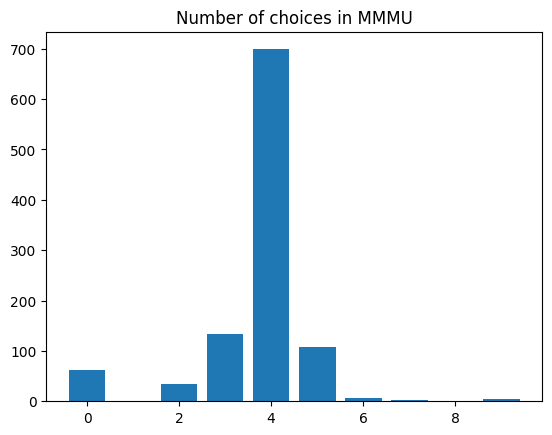

In [51]:
from matplotlib import pyplot as plt
from collections import Counter

non_mc_dataset = [item for item in dataset if item["answer"] not in "ABCDEFGHIJKLMNOPQRSTUVWXYZ"]
mc_dataset = [item for item in dataset if item["answer"] in "ABCDEFGHIJKLMNOPQRSTUVWXYZ"]

def compute_n_choice(item):
    choices = [item[idx] for idx in "ABCDEFGHI"]
    # remove nan
    choices = [choice for choice in choices if choice == choice]
    return len(choices)


n_choices = [compute_n_choice(item) for item in dataset]
len(non_mc_dataset), len(mc_dataset)

plt.bar(Counter(n_choices).keys(), Counter(n_choices).values())
plt.title("Number of choices in MMMU")